In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

Verified

In [ ]:
import requests
import pandas as pd
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Parameters
window_size = 50  # Number of most recent prices to keep in the window
interval = 60  # Fetch new price every 60 seconds
api_key = os.getenv("API_KEY")  # Finnhub API key

def fetch_latest_price(ticker):
    """Fetch the latest stock price from Finnhub API."""
    url = f"https://finnhub.io/api/v1/quote?symbol={ticker}&token={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        data = response.json()
        
        if 'c' in data:
            latest_price = data['c']  # Current price
            return time.strftime('%Y-%m-%d %H:%M:%S'), latest_price
        else:
            print(f"Error fetching data for {ticker}: {data.get('error', 'Unknown error')}")
            return None, None
    except requests.RequestException as e:
        print(f"Failed to get ticker '{ticker}' due to: {e}")
        return None, None

def get_valid_ticker():
    """Ask the user for a valid ticker until one is provided."""
    while True:
        ticker = input("Please enter a valid stock ticker: ").upper()
        timestamp, price = fetch_latest_price(ticker)
        if price is not None:
            print(f"Valid ticker '{ticker}' provided.")
            return ticker
        else:
            print(f"'{ticker}' is not a valid stock ticker or data could not be retrieved. Please try again.")

def update_csv(stock_data, csv_file, ticker):
    """Update the CSV file with a new row and maintain a moving window."""
    timestamp, price = fetch_latest_price(ticker)
    
    if price is not None:
        new_data = pd.DataFrame({"Datetime": [timestamp], "Price": [price]})
        stock_data = pd.concat([stock_data, new_data], ignore_index=True).tail(window_size)
        stock_data.to_csv(csv_file, index=False)
        print(f"Updated CSV at {timestamp} with price {price}")
    else:
        print(f"Failed to fetch data for ticker {ticker}")

    return stock_data

# Main script
if __name__ == "__main__":
    # Get the current working directory (notebooks)
    current_dir = os.getcwd()

    # Go up one level to the parent directory
    parent_dir = os.path.dirname(current_dir)

    # Construct the path to the stock_data directory
    stock_data_dir = os.path.join(parent_dir, "stock_data")

    # Create the stock_data directory if it doesn't exist
    os.makedirs(stock_data_dir, exist_ok=True)

    ticker = get_valid_ticker()
    csv_file = os.path.join(stock_data_dir, f"{ticker}.csv")

    # Initialize or load existing CSV file
    try:
        stock_data = pd.read_csv(csv_file)
    except FileNotFoundError:
        stock_data = pd.DataFrame(columns=["Datetime", "Price"])

    # Main loop to continuously fetch data and update the CSV
    while True:
        stock_data = update_csv(stock_data, csv_file, ticker)
        time.sleep(interval)

Verified

In [ ]:
import requests
import pandas as pd
import time
import os
from dotenv import load_dotenv
from datetime import datetime, time as dt_time
from pytz import timezone
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Load environment variables
load_dotenv()

# Parameters
window_size = 50  # Number of most recent prices to keep in the window
interval = 60  # Fetch new price every 60 seconds
api_key = os.getenv("API_KEY")  # Finnhub API key

def is_trading_time():
    now = datetime.now(timezone('US/Eastern'))
    
    # Check if it's a weekday
    if now.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        return False
    
    # Check if it's a holiday
    us_holidays = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    if now.strftime('%Y-%m-%d') in us_holidays.holidays():
        return False
    
    # Check if it's within market hours (9:30 AM to 4:00 PM Eastern Time)
    market_start = dt_time(9, 30)
    market_end = dt_time(16, 0)
    current_time = now.time()
    
    return market_start <= current_time <= market_end

def fetch_latest_price(ticker):
    """Fetch the latest stock price from Finnhub API."""
    url = f"https://finnhub.io/api/v1/quote?symbol={ticker}&token={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises an HTTPError for bad responses
        data = response.json()
        
        if 'c' in data:
            latest_price = data['c']  # Current price
            return time.strftime('%Y-%m-%d %H:%M:%S'), latest_price
        else:
            print(f"Error fetching data for {ticker}: {data.get('error', 'Unknown error')}")
            return None, None
    except requests.RequestException as e:
        print(f"Failed to get ticker '{ticker}' due to: {e}")
        return None, None

def get_valid_ticker():
    """Ask the user for a valid ticker until one is provided."""
    while True:
        ticker = input("Please enter a valid stock ticker: ").upper()
        timestamp, price = fetch_latest_price(ticker)
        if price is not None:
            print(f"Valid ticker '{ticker}' provided.")
            return ticker
        else:
            print(f"'{ticker}' is not a valid stock ticker or data could not be retrieved. Please try again.")

def update_csv(stock_data, csv_file, ticker):
    """Update the CSV file with a new row and maintain a moving window."""
    if not is_trading_time():
        print(f"Not trading time. Skipping update at {datetime.now(timezone('US/Eastern'))}")
        return stock_data

    timestamp, price = fetch_latest_price(ticker)
    
    if price is not None:
        new_data = pd.DataFrame({"Datetime": [timestamp], "Price": [price]})
        stock_data = pd.concat([stock_data, new_data], ignore_index=True).tail(window_size)
        stock_data.to_csv(csv_file, index=False)
        print(f"Updated CSV at {timestamp} with price {price}")
    else:
        print(f"Failed to fetch data for ticker {ticker}")

    return stock_data

# Main script
if __name__ == "__main__":
    # Get the current working directory (notebooks)
    current_dir = os.getcwd()

    # Go up one level to the parent directory
    parent_dir = os.path.dirname(current_dir)

    # Construct the path to the stock_data directory
    stock_data_dir = os.path.join(parent_dir, "stock_data")

    # Create the stock_data directory if it doesn't exist
    os.makedirs(stock_data_dir, exist_ok=True)

    ticker = get_valid_ticker()
    csv_file = os.path.join(stock_data_dir, f"{ticker}.csv")

    # Initialize or load existing CSV file
    try:
        stock_data = pd.read_csv(csv_file)
    except FileNotFoundError:
        stock_data = pd.DataFrame(columns=["Datetime", "Price"])

    # Main loop to continuously fetch data and update the CSV
    while True:
        stock_data = update_csv(stock_data, csv_file, ticker)
        time.sleep(interval)

Valid ticker 'AAPL' provided.
Updated CSV at 2024-10-24 23:14:28 with price 230.57


C:\Users\rauna\AppData\Local\Temp\ipykernel_34204\2451692705.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_data = pd.concat([stock_data, new_data], ignore_index=True).tail(window_size)


Untested

File found: C:\Users\rauna\PycharmProjects\Derivative_Based_Stock_Prediction\stock_data\AAPL.csv
Degree 2: Train MSE = 0.6318, Test MSE = 0.5531
Degree 3: Train MSE = 0.0261, Test MSE = 0.2097
Degree 4: Train MSE = 0.0077, Test MSE = 0.0355


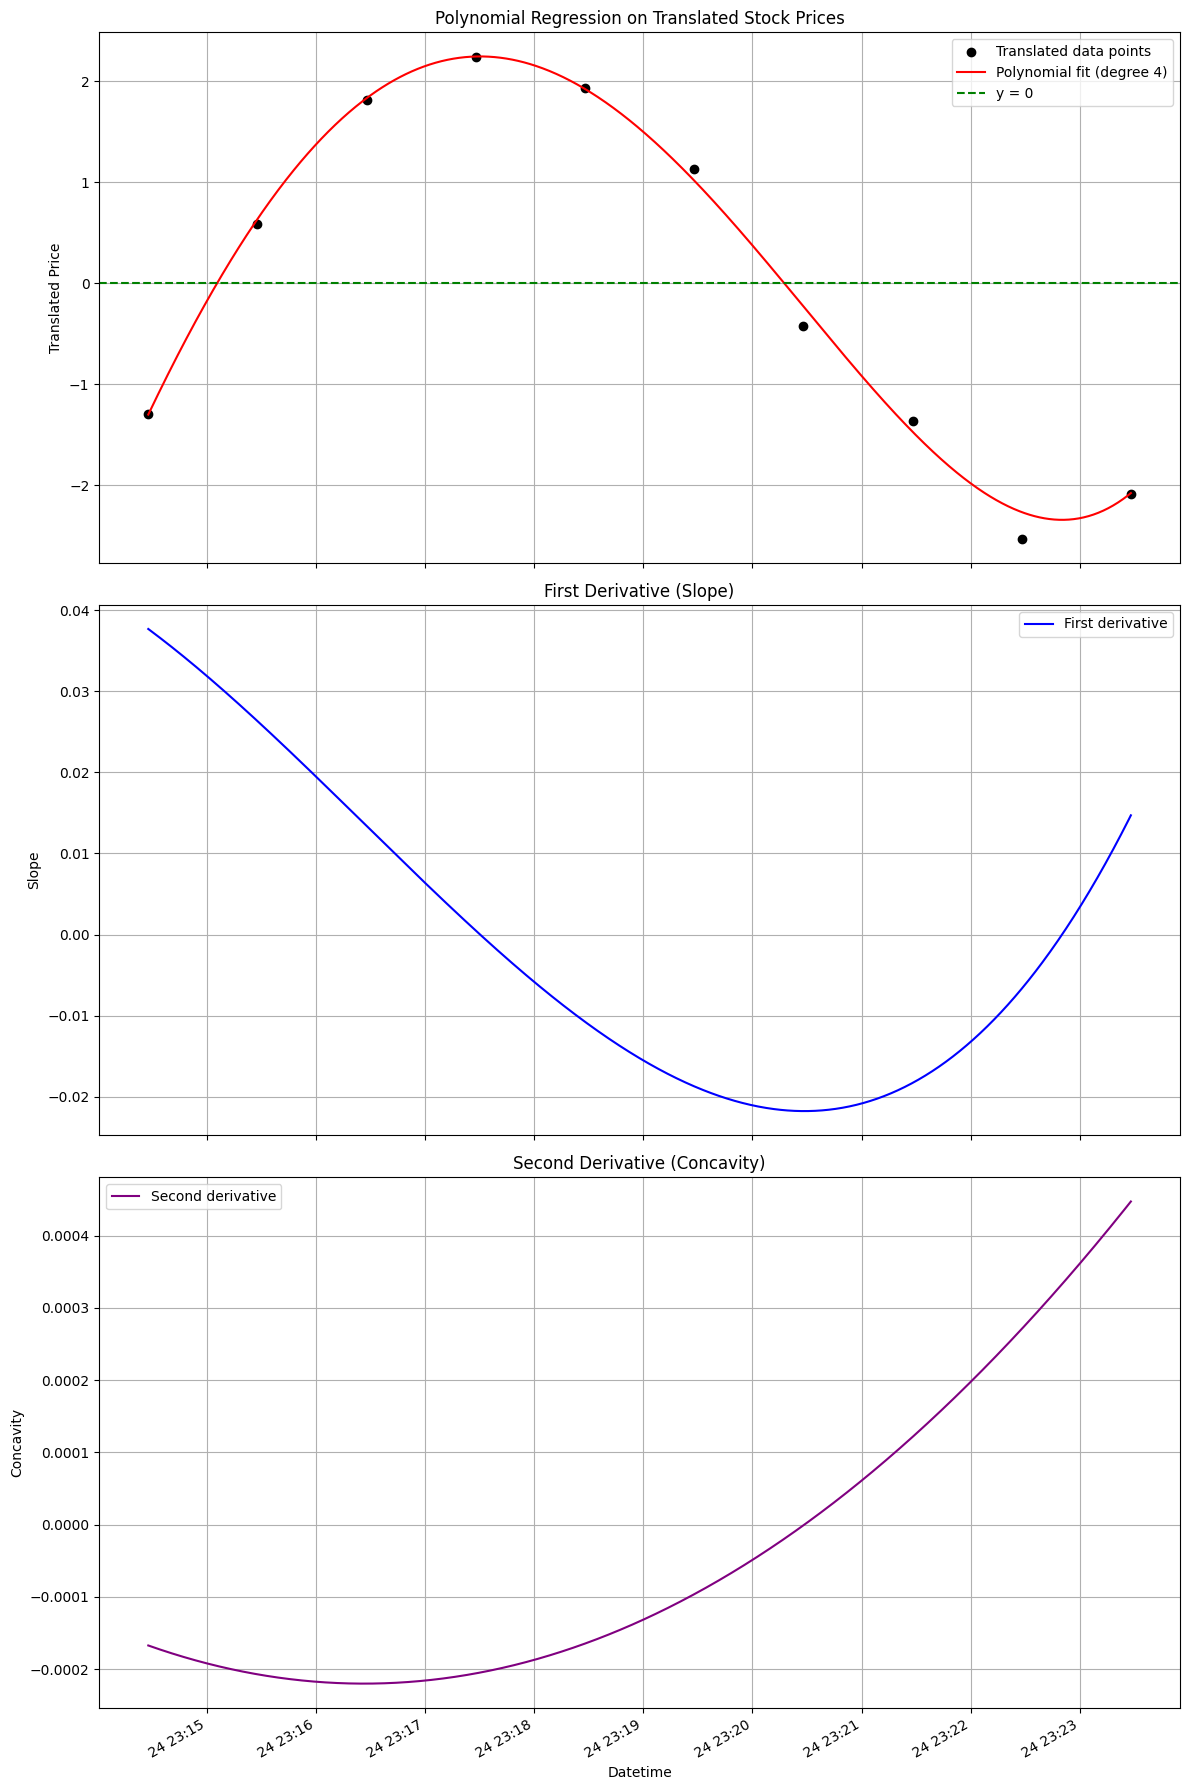


Best polynomial coefficients (highest degree first):
  3.1301e-10 * x^4
  -1.4841e-07 * x^3
  -8.3627e-05 * x^2
  3.7710e-02 * x^1
  -1.2988e+00 * x^0

Regression function:
          4             3             2
3.13e-10 x - 1.484e-07 x - 8.363e-05 x + 0.03771 x - 1.299

Derivative function (for slope):
           3             2
1.252e-09 x - 4.452e-07 x - 0.0001673 x + 0.03771

Second derivative function (for concavity):
           2
3.756e-09 x - 8.905e-07 x - 0.0001673

Prediction for the next 1/4 section:
Predicted slope: 0.1070
Predicted concavity: 0.0009

Projected price at 2024-10-24 23:25:43: $237.25

Based on the analysis, the polynomial is predicted to be increasing with upward curvature in the next 1/4 section of the graph.

Relative extrema within the data range:
Maximum at 2024-10-24 23:17:30: $234.11
Minimum at 2024-10-24 23:22:50: $229.53

Predicted relative extrema in the next 1/4 section:


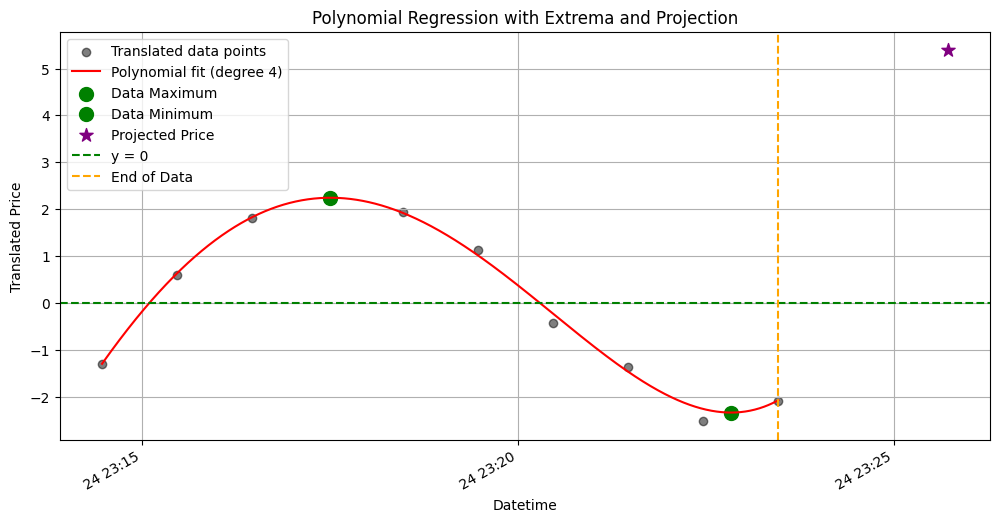

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def get_valid_csv_filename():
    while True:
        base_filename = input("Enter the base name of the CSV file (without .csv extension): ")
        filename = f"{base_filename}.csv"
        
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        stock_data_dir = os.path.join(parent_dir, "stock_data")
        full_path = os.path.join(stock_data_dir, filename)
        
        if os.path.isfile(full_path):
            print(f"File found: {full_path}")
            return full_path
        else:
            print(f"File not found: {filename}")
            print("Please try again.")

def fit_and_evaluate(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    y_pred = p(x)
    mse = mean_squared_error(y, y_pred)
    return coeffs, p, mse

def find_extrema(p, dp, d2p, x_min, x_max, n_points=1000):
    x_vals = np.linspace(x_min, x_max, n_points)
    y_vals = dp(x_vals)
    
    # Find where the derivative changes sign
    sign_changes = np.where(np.diff(np.sign(y_vals)))[0]
    
    extrema = []
    for idx in sign_changes:
        x_extremum = (x_vals[idx] + x_vals[idx + 1]) / 2
        y_extremum = p(x_extremum)
        if d2p(x_extremum) > 0:
            extremum_type = "Minimum"
        elif d2p(x_extremum) < 0:
            extremum_type = "Maximum"
        else:
            extremum_type = "Inflection point"
        
        extrema.append((x_extremum, y_extremum, extremum_type))
    
    return extrema

# Get a valid CSV file path
csv_file = get_valid_csv_filename()

# Read the CSV file
df = pd.read_csv(csv_file)

# Convert Datetime to numeric values for regression
df['Datetime'] = pd.to_datetime(df['Datetime'])
x = (df['Datetime'] - df['Datetime'].min()).dt.total_seconds().values

# Extract prices
prices = df['Price'].values

# Compute average price and translate prices
avg_price = np.mean(prices)
translated_prices = prices - avg_price

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, translated_prices, test_size=0.2, random_state=42)

# Fit polynomials of degree 2, 3, and 4
degrees = [2, 3, 4]
models = []

for degree in degrees:
    coeffs, p, mse = fit_and_evaluate(x_train, y_train, degree)
    test_mse = mean_squared_error(y_test, p(x_test))
    models.append((degree, coeffs, p, mse, test_mse))
    print(f"Degree {degree}: Train MSE = {mse:.4f}, Test MSE = {test_mse:.4f}")

# Select the best model (lowest test MSE)
best_model = min(models, key=lambda m: m[4])
degree, coeffs, p, _, _ = best_model

# Generate points for plotting the fitted curve
x_plot = np.linspace(x.min(), x.max(), 1000)
y_plot = p(x_plot)

# Calculate derivatives
dp = p.deriv()
d2p = dp.deriv()

# Plot the original data, fitted curve, and derivatives
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# Original data and fitted curve
ax1.scatter(df['Datetime'], translated_prices, color='black', label='Translated data points')
ax1.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), y_plot, color='red', label=f'Polynomial fit (degree {degree})')
ax1.axhline(y=0, color='green', linestyle='--', label='y = 0')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Translated Price')
ax1.set_title('Polynomial Regression on Translated Stock Prices')
ax1.legend()
ax1.grid(True)

# First derivative
ax2.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), dp(x_plot), color='blue', label='First derivative')
ax2.set_xlabel('Datetime')
ax2.set_ylabel('Slope')
ax2.set_title('First Derivative (Slope)')
ax2.legend()
ax2.grid(True)

# Second derivative
ax3.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), d2p(x_plot), color='purple', label='Second derivative')
ax3.set_xlabel('Datetime')
ax3.set_ylabel('Concavity')
ax3.set_title('Second Derivative (Concavity)')
ax3.legend()
ax3.grid(True)

plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.tight_layout()
plt.show()

# Print the polynomial coefficients
print("\nBest polynomial coefficients (highest degree first):")
for i, coef in enumerate(coeffs):
    print(f"  {coef:.4e} * x^{degree - i}")

# Print the regression function
print("\nRegression function:")
print(p)

# Print the derivative function
print("\nDerivative function (for slope):")
print(dp)

# Print the second derivative function
print("\nSecond derivative function (for concavity):")
print(d2p)

# Predict behavior and prices for the next 1/4 section
x_range = x.max() - x.min()
x_pred = x.max() + 0.25 * x_range
y_pred = p(x_pred)
slope_pred = dp(x_pred)
concavity_pred = d2p(x_pred)

print("\nPrediction for the next 1/4 section:")
print(f"Predicted slope: {slope_pred:.4f}")
print(f"Predicted concavity: {concavity_pred:.4f}")

# Calculate projected price
projected_price = y_pred + avg_price
projected_date = df['Datetime'].max() + timedelta(seconds=int(0.25 * x_range))

print(f"\nProjected price at {projected_date}: ${projected_price:.2f}")

if slope_pred > 0:
    trend = "increasing"
elif slope_pred < 0:
    trend = "decreasing"
else:
    trend = "stable"

if concavity_pred > 0:
    curvature = "upward"
elif concavity_pred < 0:
    curvature = "downward"
else:
    curvature = "linear"

print(f"\nBased on the analysis, the polynomial is predicted to be {trend} with {curvature} curvature in the next 1/4 section of the graph.")

# Find relative extrema
data_extrema = find_extrema(p, dp, d2p, x.min(), x.max())
predicted_extrema = find_extrema(p, dp, d2p, x.max(), x_pred)

print("\nRelative extrema within the data range:")
for x_ext, y_ext, ext_type in data_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    price = y_ext + avg_price
    print(f"{ext_type} at {date}: ${price:.2f}")

print("\nPredicted relative extrema in the next 1/4 section:")
for x_ext, y_ext, ext_type in predicted_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    price = y_ext + avg_price
    print(f"{ext_type} at {date}: ${price:.2f}")

# Visualize the extrema
plt.figure(figsize=(12, 6))
plt.scatter(df['Datetime'], translated_prices, color='black', label='Translated data points', alpha=0.5)
plt.plot(df['Datetime'].min() + pd.to_timedelta(x_plot, unit='s'), y_plot, color='red', label=f'Polynomial fit (degree {degree})')

# Plot data range extrema
for x_ext, y_ext, ext_type in data_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    plt.scatter(date, y_ext, color='green', s=100, marker='o', label=f'Data {ext_type}' if ext_type not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot predicted range extrema
for x_ext, y_ext, ext_type in predicted_extrema:
    date = df['Datetime'].min() + timedelta(seconds=int(x_ext))
    plt.scatter(date, y_ext, color='blue', s=100, marker='s', label=f'Predicted {ext_type}' if ext_type not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot the projected price point
plt.scatter(projected_date, y_pred, color='purple', s=100, marker='*', label='Projected Price')

plt.axhline(y=0, color='green', linestyle='--', label='y = 0')
plt.axvline(x=df['Datetime'].max(), color='orange', linestyle='--', label='End of Data')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Translated Price')
plt.title('Polynomial Regression with Extrema and Projection')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

Verified